In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

## State variables

$$ \mathit{\mathbf{x}}  = [x, y, z] $$

where z = 0 in 2D scene

## Process Model 

In [2]:
# Fictitious data: System ctrl input 

linear_vel = np.array([.5, 0, 0])
angular_vel = np.array([0, 0, 0])
u = np.append(linear_vel, angular_vel, axis=0)

In [3]:
def skew(vector):
    """
    this function returns a numpy array with the skew symmetric cross product matrix for vector.
    the skew symmetric cross product matrix is defined such that
    np.cross(a, b) = np.dot(skew(a), b)

    :param vector: An array like vector to create the skew symmetric cross product matrix for
    :return: A numpy array of the skew symmetric cross product vector
    """

    return np.array(
        [
            [0, -vector[2], vector[1]],
            [vector[2], 0, -vector[0]],
            [-vector[1], vector[0], 0],
        ]
    )

In [4]:
def f_contact(x, dt, u):
    A = np.identity(3)
    B = -dt * np.append(np.identity(3), -skew(x), axis=1)
    prior_ = A @ x - B @ u # DYX: it should be plus, but here there's a coordinate translation needed to be done !!!
    return prior_

In [5]:
# Process Noise
Q = np.array([[.001, 0, 0], [0, .001, 0], [0, 0, .00001]])

## Measurement Model

In [6]:
def polyfit2d(x, y, z, kx=5, ky=5, order=None):
    """
    Two dimensional polynomial fitting by least squares.
    Fits the functional form f(x,y) = z.

    Notes
    -----
    Resultant fit can be plotted with:
    np.polynomial.polynomial.polygrid2d(x, y, soln.reshape((kx+1, ky+1)))

    Parameters
    ----------
    x, y: array-like, 1d
        x and y coordinates.
    z: np.ndarray, 2d
        Surface to fit.
    kx, ky: int, default is 3
        Polynomial order in x and y, respectively.
    order: int or None, default is None
        If None, all coefficients up to maxiumum kx, ky, ie. up to and including x^kx*y^ky, are considered.
        If int, coefficients up to a maximum of kx+ky <= order are considered.

    Returns
    -------
    Return paramters from np.linalg.lstsq.

    soln: np.ndarray
        Array of polynomial coefficients.
    residuals: np.ndarray
    rank: int
    s: np.ndarray

    """

    # grid coords
    x, y = np.meshgrid(x, y)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((kx + 1, ky + 1))

    # solve array
    a = np.zeros((coeffs.size, x.size))

    # for each coefficient produce array x^i, y^j
    for index, (i, j) in enumerate(np.ndindex(coeffs.shape)):
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = coeffs[i, j] * x**i * y**j
        a[index] = arr.ravel()

    # do leastsq fitting and return leastsq result
    print(a.T.shape, np.ravel(z).shape)
    return np.linalg.lstsq(a.T, np.ravel(z), rcond=None)

In [7]:
import pandas as pd

dataframe = pd.read_excel("FullRangeData.xlsx", sheet_name="Formated_MannulyFixed")
z = np.array(dataframe)[:, 2]

x = np.linspace(10, 90, 17)
y = np.linspace(115, 160, 10)

coeff, r, rank, s = polyfit2d(x, y, z)

(170, 36) (170,)


In [8]:
from sklearn.metrics import r2_score

fitted_surf = np.polynomial.polynomial.polygrid2d(x, y, coeff.reshape((6, 6)))

rms = np.sqrt(np.mean((z.reshape(10, 17).T - fitted_surf) ** 2))
print("RMS residual =", rms)
score = r2_score(z.reshape(10, 17).T, fitted_surf)
print("R-squared value =", score)

RMS residual = 0.23193393244515742
R-squared value = 0.9944280222772985


In [9]:
def h_contact(x):
    return np.polynomial.polynomial.polygrid2d(x[0], x[1], coeff.reshape((6, 6)))

Fictitious data

In [10]:
# Start point
X_start = 10
Y_start = 140

# End point
X_end = 90
Y_end = 140

trajecotry_ = np.polynomial.polynomial.polygrid2d(
    np.linspace(X_start, X_end, 160),
    140,
    coeff.reshape((6, 6)),
)

# format measurements
zs = [np.array([trajecotry_[i]]) for i in range(trajecotry_.shape[0])]

In [11]:
# Measurement Noise
R = np.array([[rms**2]])

## Implementation of filter

In [12]:
dt = 1.0

In [13]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

sigmas = MerweScaledSigmaPoints(3, alpha=.1, beta=2., kappa=0.)
ukf = UKF(dim_x=3, dim_z=1, fx=f_contact,
          hx=h_contact, dt=dt, points=sigmas)

ukf.x = np.array([10, 140, 0])
ukf.R = R
ukf.Q = Q

In [14]:
ukf

UnscentedKalmanFilter object
x = [ 10 140   0]
P = [[1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.]]
x_prior = [0. 0. 0.]
P_prior = [[1. 0. 0.]
           [0. 1. 0.]
           [0. 0. 1.]]
Q = [[1.e-03 0.e+00 0.e+00]
     [0.e+00 1.e-03 0.e+00]
     [0.e+00 0.e+00 1.e-05]]
R = [[0.05379335]]
S = [[0.]]
K = [[0. 0. 0.]].T
y = [0.]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
sigmas_f = [[0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]
            [0. 0. 0.]]
h = [[0. 0. 0. 0. 0. 0. 0.]].T
Wm = [-99.          16.66666667  16.66666667  16.66666667  16.66666667
       16.66666667  16.66666667]
Wc = [-96.01        16.66666667  16.66666667  16.66666667  16.66666667
       16.66666667  16.66666667]
residual_x = <ufunc 'subtract'>
residual_z = <ufunc 'subtract'>
msqrt = <function cholesky at 0x000001E02FE10310>
hx = <function h_contact at 0x000001E02A398A60>
fx = <function f_co

[[ 1.04304696e+01  1.40044737e+02  1.75715472e-16]
 [ 1.08930756e+01  1.40070951e+02  9.36438244e-17]
 [ 1.13715670e+01  1.40088059e+02 -4.64858155e-16]
 [ 1.18589277e+01  1.40099938e+02 -8.10800579e-16]
 [ 1.23516100e+01  1.40108415e+02 -5.31092242e-16]
 [ 1.28475927e+01  1.40114423e+02 -2.72456376e-16]
 [ 1.33456136e+01  1.40118475e+02 -6.98821050e-17]
 [ 1.38448302e+01  1.40120868e+02 -9.03221920e-16]
 [ 1.43446567e+01  1.40121795e+02 -1.21734343e-15]
 [ 1.48446824e+01  1.40121409e+02 -1.80943933e-15]
 [ 1.53446269e+01  1.40119852e+02 -1.45817692e-15]
 [ 1.58443135e+01  1.40117273e+02 -2.08702173e-15]
 [ 1.63436498e+01  1.40113837e+02 -1.86575998e-15]
 [ 1.68426106e+01  1.40109721e+02 -1.44035300e-15]
 [ 1.73412223e+01  1.40105106e+02 -1.29187402e-15]
 [ 1.78395464e+01  1.40100175e+02 -1.75445245e-15]
 [ 1.83376658e+01  1.40095098e+02 -1.75487678e-15]
 [ 1.88356717e+01  1.40090028e+02 -1.53292743e-15]
 [ 1.93336536e+01  1.40085098e+02 -1.29224730e-15]
 [ 1.98316923e+01  1.40080415e+

UKF standard deviation 59.917 meters


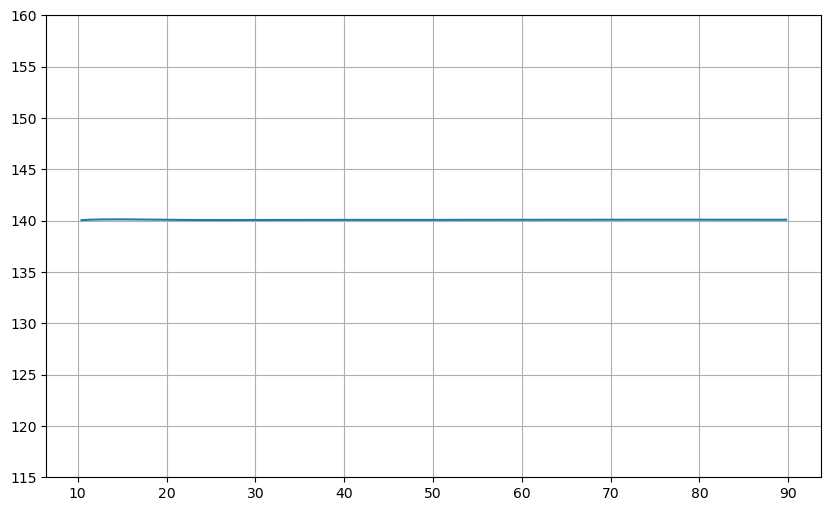

In [15]:
uxs = []
for z in zs:
    ukf.predict(u=u)
    ukf.update(z)
    uxs.append(ukf.x.copy())
uxs = np.array(uxs)
print(uxs)


plt.figure(figsize=(10, 6))
plt.grid()
plt.ylim([115, 160])
plt.plot(uxs[:, 0], uxs[:, 1], label='Estimated Trajectory')
print(f'UKF standard deviation {np.std(uxs - zs):.3f} meters')